In [16]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
import csv

In [17]:
print (os.getcwd())

/home/xiaoliangjiang/work


In [18]:
fn = "stops.txt"
with open(fn, "r") as f:
    reader = csv.reader(f)
    header = next(reader)
    data = {}
    for column in header:
        data[column] = []
    for row in reader:
        for column, value in zip(header, row):
            data[column].append(value)

In [21]:
class Dataset:
    def __init__(self, data):
        self.data = data
        
    def convert(self, column, dtype):
        self.data[column] = np.array(self.data[column], dtype=dtype)
        
    def columns(self):
        return self.data.keys()
    
    def filter_eq(self, column, value):
        good = (self.data[column] == value)
        new_data = {}
        for column in self.data:
            new_data[column] = self.data[column][good]
        return Dataset(new_data)
    
    def filter_lt(self, column, value):
        good = (self.data[column] < value)
        new_data = {}
        for column in self.data:
            new_data[column] = self.data[column][good]
        return Dataset(new_data)
    
    def filter_gt(self, column, value):
        good = (self.data[column] > value)
        new_data = {}
        for column in self.data:
            new_data[column] = self.data[column][good]
        return Dataset(new_data)
    
    def filter_ne(self, column, value):
        good = (self.data[column] != value)
        new_data = {}
        for column in self.data:
            new_data[column] = self.data[column][good]
        return Dataset(new_data)
    
    def size(self):
        for key in self.data:
            return self.data[key].size

    def split(self, column):
        new_datasets = {}
        for split_value in np.unique(self.data[column]):
            new_datasets[split_value] = self.filter_eq(column, split_value)
        return new_datasets

    def stats(self):
        statistics = {}
        for key in self.data:
            if self.data[key].dtype not in ("float", "int"):
                continue
            values = self.data[key]
            statistics[key] = (values.min(), values.max(), values.std(), values.mean())
        return statistics
    
    def compare(self, other):
        stats1 = self.stats()
        stats2 = other.stats()
        for column in self.columns():
            if column not in stats1: continue
            print("Column '{0:25s}'".format(column))
            for s1, s2 in zip(stats1[column], stats2[column]):
                print("    {0} vs {1}".format(s1, s2))
    
    def plot(self, x_column, y_column):
        plt.plot(self.data[x_column], self.data[y_column], '.')

In [73]:
header

['stop_id',
 'stop_code',
 'stop_name',
 'stop_desc',
 'stop_lat',
 'stop_lon',
 'zone_id',
 'stop_url',
 'location_type',
 'parent_station']

In [76]:
stopsdata= Dataset(data)
value_types = {'stop_ids': 'str',
               'stop_code': 'str',
               'stop_name':'str',
               'stop_desc':'str',
               'stop_lat':'float',
               'stop_lon':'float',
               'zone_id':'float',
               'stop_url':'str',
               'location_type':'str',
               'parent_station':'str'}
for v in stopsdata.columns():
    stopsdata.convert(v, value_types.get(v, "str"))

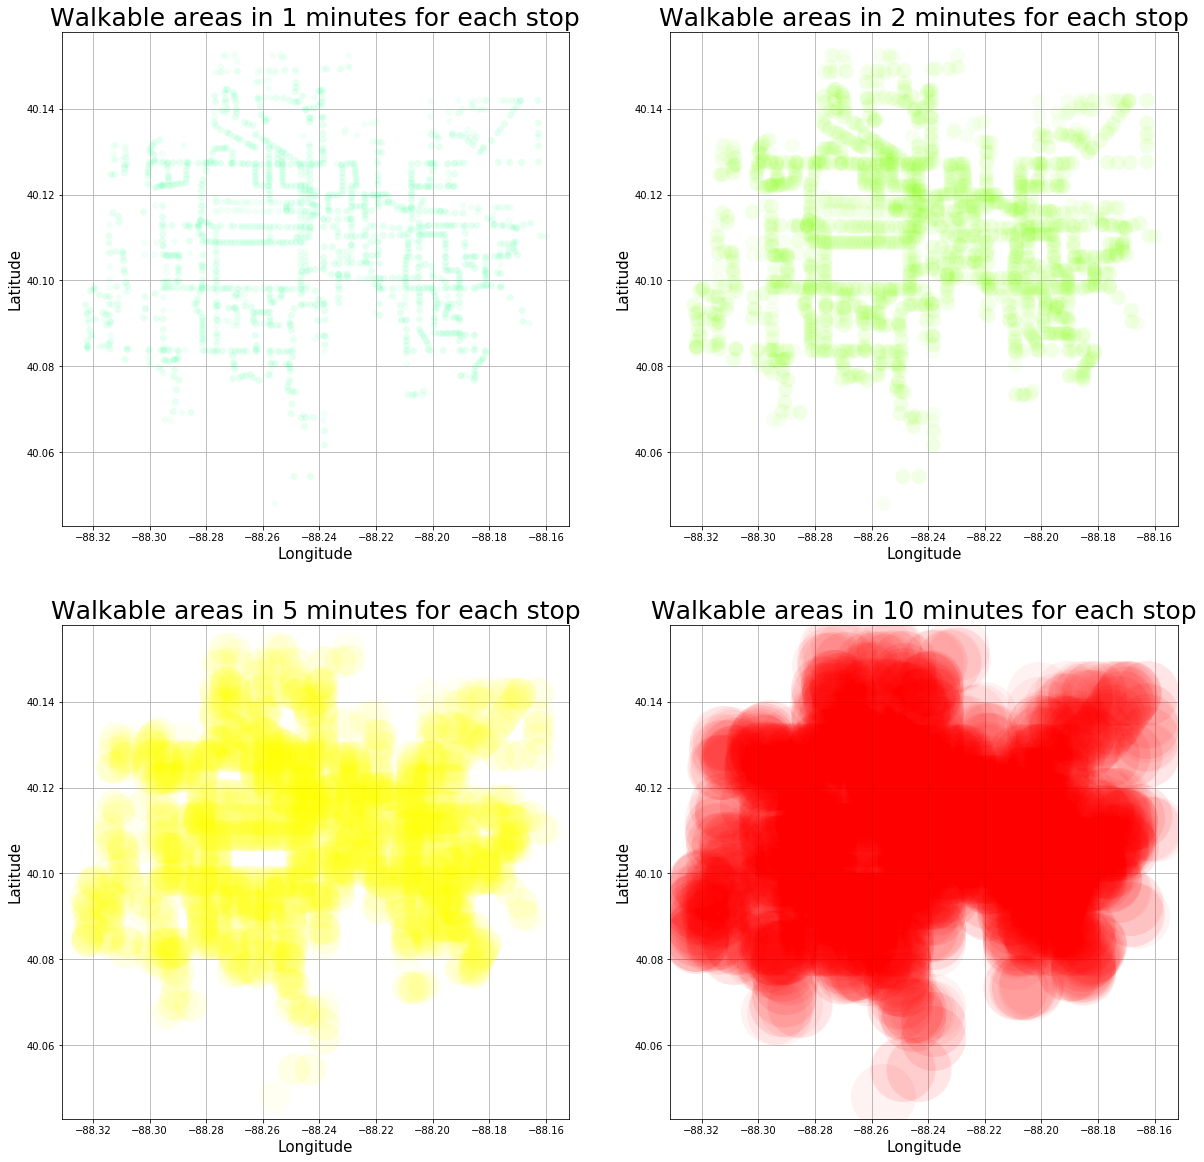

In [135]:
plt.subplot(221)
plt.rcParams["figure.figsize"] = (20, 20)
plt.grid()
plt.xlabel("Longitude",fontsize=15)
plt.ylabel("Latitude",fontsize=15)
plt.title("Walkable areas in 1 minutes for each stop", fontsize=25)
plt.plot(data["stop_lon"],data["stop_lat"],c='#00ff80',marker='o',markersize=7,mec='none',ls='',alpha=0.05)
plt.subplot(222)
plt.rcParams["figure.figsize"] = (20, 20)
plt.grid()
plt.xlabel("Longitude",fontsize=15)
plt.ylabel("Latitude",fontsize=15)
plt.title("Walkable areas in 2 minutes for each stop", fontsize=25)
plt.plot(data["stop_lon"],data["stop_lat"],c='#80ff00',marker='o',markersize=15,mec='none',ls='',alpha=0.05)
plt.subplot(223)
plt.rcParams["figure.figsize"] = (20, 20)
plt.grid()
plt.xlabel("Longitude",fontsize=15)
plt.ylabel("Latitude",fontsize=15)
plt.title("Walkable areas in 5 minutes for each stop", fontsize=25)
plt.plot(data["stop_lon"],data["stop_lat"],c='#ffff00',marker='o',markersize=32,mec='none',ls='',alpha=0.05)
plt.subplot(224)
plt.rcParams["figure.figsize"] = (20, 20)
plt.grid()
plt.xlabel("Longitude",fontsize=15)
plt.ylabel("Latitude",fontsize=15)
plt.title("Walkable areas in 10 minutes for each stop", fontsize=25)
plt.plot(data["stop_lon"],data["stop_lat"],c='#ff0000',marker='o',markersize=65,mec='none',ls='',alpha=0.05)

# explaination
Accroding to the google map, 0.02 longitude at 40.06N latitude equals 1.1 miles. So the circle here represent a circle area with r=0.275mile which means an area which only take 5 minutes to walk.

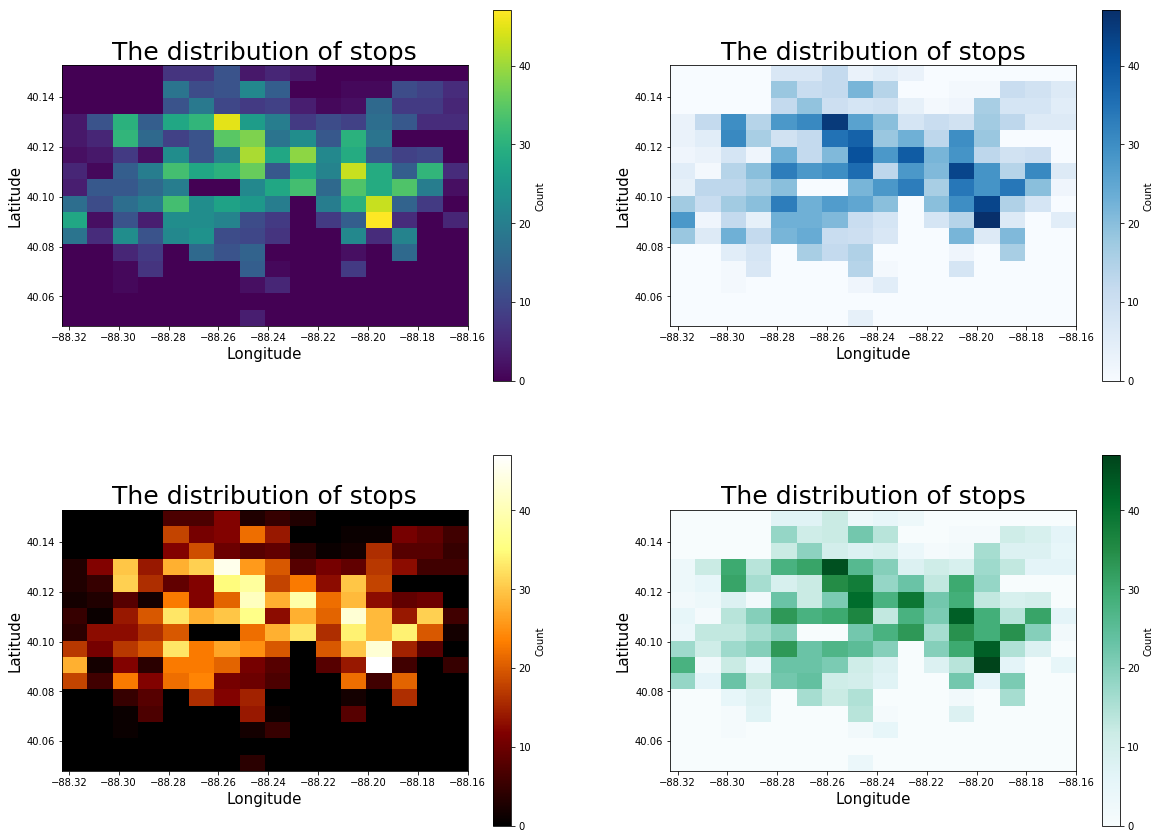

In [160]:
stats=stopsdata.stats()
plt.rcParams["figure.figsize"] = (20, 15)
stats=stopsdata.stats()
lon_min=stats["stop_lon"][0]
lon_max=stats["stop_lon"][1]
lat_min=stats["stop_lat"][0]
lat_max=stats["stop_lat"][1]
num_bins=16
lon=np.mgrid[lon_min:lon_max:(num_bins+1)*1j]
lat=np.mgrid[lat_min:lat_max:(num_bins+1)*1j]
tree_count=np.zeros((num_bins,num_bins))
for i in range(num_bins):
    left_lat=lat[i]
    right_lat=lat[i+1]
    filter_lat_left=stopsdata.filter_gt("stop_lat",left_lat)
    filter_lat_right=filter_lat_left.filter_lt("stop_lat",right_lat)
    for j in range(num_bins):
        left_lon=lon[j]
        right_lon=lon[j+1]
        filter_lon_left=filter_lat_right.filter_gt("stop_lon",left_lon)
        filter_lon_right=filter_lon_left.filter_lt("stop_lon",right_lon)
        tree_count[i,j] +=filter_lon_right.size()
#plt.xlim(lon_min,lon_max)
#plt.ylim(lat_min,lat_max)
plt.subplot(221)
plt.imshow(tree_count, extent=(lon_min,lon_max,lat_min,lat_max),origin="lower")
plt.xlabel("Longitude",fontsize=15)
plt.ylabel("Latitude",fontsize=15)
plt.title("The distribution of stops", fontsize=25)
color_bar=plt.colorbar()
color_bar.set_label("Count")
plt.subplot(222)
plt.imshow(tree_count, extent=(lon_min,lon_max,lat_min,lat_max),origin="lower",cmap =plt.cm.Blues)
plt.xlabel("Longitude",fontsize=15)
plt.ylabel("Latitude",fontsize=15)
plt.title("The distribution of stops", fontsize=25)
color_bar=plt.colorbar()
color_bar.set_label("Count")
plt.subplot(223)
plt.imshow(tree_count, extent=(lon_min,lon_max,lat_min,lat_max),origin="lower", cmap = plt.cm.afmhot)
plt.xlabel("Longitude",fontsize=15)
plt.ylabel("Latitude",fontsize=15)
plt.title("The distribution of stops", fontsize=25)
color_bar=plt.colorbar()
color_bar.set_label("Count")

plt.subplot(224)
plt.imshow(tree_count, extent=(lon_min,lon_max,lat_min,lat_max),origin="lower", cmap = plt.cm.BuGn)
plt.xlabel("Longitude",fontsize=15)
plt.ylabel("Latitude",fontsize=15)
plt.title("The distribution of stops", fontsize=25)
color_bar=plt.colorbar()
color_bar.set_label("Count")


# Question
How to let the ploting area be a perfect square.